In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import pickle

from catboost import CatBoostRegressor

In [4]:
df = pd.read_csv("data/diamonds_train.csv", index_col=0)
df

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997
...,...,...,...,...,...,...,...,...,...,...
40340,1.55,Premium,H,VS2,61.3,61.0,7.46,7.39,4.55,11708
40341,0.36,Ideal,D,SI1,60.6,56.0,4.58,4.63,2.79,619
40342,0.57,Very Good,I,VS2,62.2,55.0,5.33,5.34,3.32,1267
40343,1.01,Very Good,F,IF,59.6,62.0,6.47,6.56,3.88,9965


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40345 entries, 0 to 40344
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40345 non-null  float64
 1   cut      40345 non-null  object 
 2   color    40345 non-null  object 
 3   clarity  40345 non-null  object 
 4   depth    40345 non-null  float64
 5   table    40345 non-null  float64
 6   x        40345 non-null  float64
 7   y        40345 non-null  float64
 8   z        40345 non-null  float64
 9   price    40345 non-null  int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


In [6]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


## 1. Data transformation

### Cut property

In [7]:
df["cut"].unique()

array(['Ideal', 'Very Good', 'Premium', 'Good', 'Fair'], dtype=object)

In [8]:
# The cut order from high to low is: Ideal, Premium, very good, good, fair
# LabelEncoder assigns values by alphabetical order so instead a lambda is used to encode this column


df["cut"] = df["cut"].replace({"Ideal": 5, "Premium": 4, "Very Good": 3, "Good": 2, "Fair": 1})

### Color property

In [9]:
df["color"].unique()

array(['H', 'D', 'F', 'G', 'I', 'E', 'J'], dtype=object)

In [10]:
# A higher price is linked to the alphabetical order of the property 'color'. 

df["color"] = df["color"].replace({"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I":2, "J":1})

### clarity 

In [11]:
df["clarity"].unique()

array(['VS2', 'VVS2', 'VS1', 'IF', 'SI1', 'SI2', 'VVS1', 'I1'],
      dtype=object)

In [12]:
# Order considering a higer to lower price: IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1
df["clarity"] = df["clarity"].replace({"I1": 1, "VVS1": 2, "SI2": 3, "SI1": 4, "IF": 5, "VS1":6, "VVS2":7, "VS2":8})

### Correlation

<AxesSubplot:>

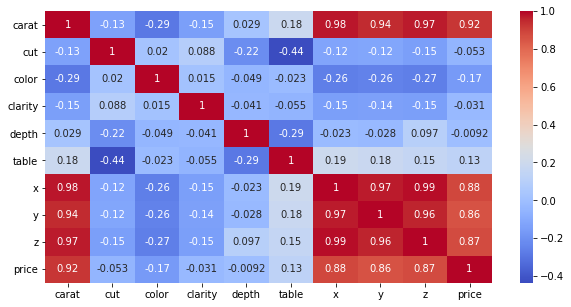

In [13]:
# Correlation between columns
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(),annot = True , cmap = "coolwarm")

# Carat, x, y and z are highly correlated to the price

## 2. Defining X and y

In [ ]:
# As cut will be used when training the model, we can ignore the table and depth as this column is based on those two

In [17]:
X = df.drop(["depth","price"], 1)
y = df["price"]

In [18]:
X.shape

(40345, 8)

In [19]:
y.shape

(40345,)

## 3. Dividing X_train, X_test, y_train, y_test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 4)

## 4. Model selection

### Ensembling

In [30]:
# Voting
from sklearn.ensemble import VotingRegressor

rnd_clf = RandomForestRegressor(n_estimators=100, random_state=4)
svr_clf = SVR()
cat_clf = CatBoostRegressor(random_state=4)

estimators = [("forest", rnd_clf), ("svr", svr_clf), ("cat", cat_clf)]

voting_clf = VotingRegressor(estimators)
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (rnd_clf, svr_clf, cat_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, np.sqrt(mean_squared_error(y_test, y_pred)))


Learning rate set to 0.07244
0:	learn: 3733.3512397	total: 52.3ms	remaining: 52.3s
1:	learn: 3503.8391451	total: 56.3ms	remaining: 28.1s
2:	learn: 3287.1818672	total: 60.4ms	remaining: 20.1s
3:	learn: 3085.7360046	total: 64.4ms	remaining: 16s
4:	learn: 2903.1249970	total: 68.6ms	remaining: 13.6s
5:	learn: 2736.2377530	total: 72.8ms	remaining: 12.1s
6:	learn: 2578.4338070	total: 77.1ms	remaining: 10.9s
7:	learn: 2435.0019065	total: 81.5ms	remaining: 10.1s
8:	learn: 2302.9415363	total: 85.5ms	remaining: 9.41s
9:	learn: 2184.5575976	total: 89.6ms	remaining: 8.87s
10:	learn: 2069.3962950	total: 93.4ms	remaining: 8.4s
11:	learn: 1964.9266979	total: 97.8ms	remaining: 8.05s
12:	learn: 1870.7237315	total: 102ms	remaining: 7.75s
13:	learn: 1784.3330052	total: 106ms	remaining: 7.49s
14:	learn: 1702.1438742	total: 110ms	remaining: 7.24s
15:	learn: 1627.9935670	total: 114ms	remaining: 7.03s
16:	learn: 1558.5395104	total: 118ms	remaining: 6.84s
17:	learn: 1492.1560247	total: 122ms	remaining: 6.68s


In [ ]:
# VotingRegressor suggests that CatBoostRegressor is the most accurate model. In any case, we will still try different models without parameters for comparison

### Random Forest

In [187]:
pipe = Pipeline(steps=[
    ("classifier", RandomForestRegressor())
])

random_forest_params = {
    "classifier": [RandomForestRegressor()],
    "classifier__random_state": [4]
    #"classifier__n_estimators": [1, 10, 100],
    #"classifier__max_features": [1,2,3]
}

search_space = [random_forest_params]

clf = GridSearchCV(estimator = pipe,
                  param_grid = search_space,
                  cv = 10,
                  verbose=1,
                  n_jobs=-1)

clf.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestRegressor())]),
             n_jobs=-1,
             param_grid=[{'classifier': [RandomForestRegressor(random_state=4)],
                          'classifier__random_state': [4]}],
             verbose=1)

In [188]:
clf = GridSearchCV(estimator=pipe, param_grid=search_space)

In [189]:
%%time
# Fit grid search
best_model = clf.fit(X_train, y_train)
# View best model
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_random_forest_1.sav'
pickle.dump(best_model, open(filename, 'wb'))

best estimator: RandomForestRegressor(random_state=4)
clf.best_params_ {'classifier': RandomForestRegressor(random_state=4), 'classifier__random_state': 4}
clf.best_score 0.979819972933251
Wall time: 34.6 s


### Polynominal 

### **!! This model takes 1:30h to process !!**

In [107]:
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {
    "polynomialfeatures__degree": np.arange(10),
    #"linearregression__fit_intercept": [True, False], 
    #"linearregression__normalize": [True, False]
}

poly_grid = GridSearchCV(PolynomialRegression(), 
                param_grid, 
                cv=10, 
                scoring="neg_mean_squared_error",
                verbose=1,
                n_jobs=-1)

clf_poly.fit(X_train, y_train)
clf_poly = GridSearchCV(PolynomialRegression(), param_grid)

In [108]:
%%time
# Fit grid search
best_model_poly = clf_poly.fit(X_train, y_train)
# View best model
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf_poly.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_poly.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_poly_1.sav'
pickle.dump(best_model_poly, open(filename, 'wb'))

C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\pipeline.py", line 307, in _fit
    **fit_params_steps[name])
  File "C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\joblib\memory.py", line 352, in __call__
    return self.func(*args, **kwargs)
  File "C:\Users\Usuario\AppData\Loca

### SVR

In [109]:
pipe = Pipeline(steps=[
    ("classifier", SVR)
])

svr_params = {
    "classifier": [SVR()],
    "classifier__kernel": ("linear", "rbf", "poly")
    #"classifier__C": [1, 10, 100, 1000],
    
}

clf_svr = GridSearchCV(estimator = pipe,
                  param_grid = svr_params,
                  cv = 10,
                  verbose=1,
                  n_jobs=-1)

clf_svr.fit(X_train, y_train)
clf_svr = GridSearchCV(estimator=pipe, param_grid=search_space)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


In [110]:
%%time
# Fit grid search
best_model_svr = clf_svr.fit(X_train, y_train)
# View best model
print("best estimator:", best_model.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf_svr.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_svr.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_svr_1.sav'
pickle.dump(best_model_svr, open(filename, 'wb'))

best estimator: LinearRegression()
clf.best_params_ {'classifier': LinearRegression()}
clf.best_score 0.8784415219930309
Wall time: 56 ms


### Catboost

In [16]:
pipe = Pipeline(steps=[
    ("classifier", CatBoostRegressor())
])

catboost_params = {
    "classifier": [CatBoostRegressor()],
    "classifier__iterations": [100,500],
    "classifier__depth": [7,10],
    "classifier__l2_leaf_reg": [5,10,100],
    "classifier__border_count": [10,50,100],
    "classifier__random_strength": [0.2,0.8],
    "classifier__eval_metric": ["RMSE"],
    "classifier__random_state": [4] 

}
                
clf_cat = GridSearchCV(estimator = pipe,
                  param_grid = catboost_params,
                  cv = 10,
                  verbose=2,
                  n_jobs=-1)

clf_cat.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
0:	learn: 3871.8441672	total: 162ms	remaining: 1m 20s
1:	learn: 3765.4790112	total: 176ms	remaining: 43.8s
2:	learn: 3662.2945903	total: 189ms	remaining: 31.4s
3:	learn: 3563.8132624	total: 203ms	remaining: 25.2s
4:	learn: 3467.0703658	total: 217ms	remaining: 21.4s
5:	learn: 3373.8296523	total: 231ms	remaining: 19s
6:	learn: 3283.4217075	total: 245ms	remaining: 17.3s
7:	learn: 3195.5800352	total: 260ms	remaining: 16s
8:	learn: 3110.3562762	total: 276ms	remaining: 15.1s
9:	learn: 3027.2555286	total: 290ms	remaining: 14.2s
10:	learn: 2947.3338025	total: 305ms	remaining: 13.5s
11:	learn: 2870.0652816	total: 320ms	remaining: 13s
12:	learn: 2795.0005145	total: 333ms	remaining: 12.5s
13:	learn: 2723.2282557	total: 350ms	remaining: 12.1s
14:	learn: 2652.7431228	total: 364ms	remaining: 11.8s
15:	learn: 2584.6528596	total: 379ms	remaining: 11.5s
16:	learn: 2519.0143711	total: 395ms	remaining: 11.2s
17:	learn: 2455.1792516	total: 410

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        <catboost.core.CatBoostRegressor object at 0x00000286A8B9D408>)]),
             n_jobs=-1,
             param_grid={'classifier': [<catboost.core.CatBoostRegressor object at 0x00000286A8B9D208>],
                         'classifier__border_count': [10, 50, 100],
                         'classifier__depth': [7, 10],
                         'classifier__eval_metric': ['RMSE'],
                         'classifier__iterations': [100, 500],
                         'classifier__l2_leaf_reg': [5, 10, 100],
                         'classifier__random_state': [4],
                         'classifier__random_strength': [0.2, 0.8]},
             verbose=2)

In [17]:
%%time
# Fit grid search
best_model_cat = clf_cat.fit(X_train, y_train)
# View best model
print("best estimator:", best_model_cat.best_estimator_.get_params()['classifier'])
print("clf.best_params_", clf_cat.best_params_)
# Mean cross-validated score of the best_estimator
print("clf.best_score", clf_cat.best_score_)
#SAVE MODEL
# save the model to disk
filename = 'model_cat_1.sav'
pickle.dump(best_model_cat, open(filename, 'wb'))

Fitting 10 folds for each of 72 candidates, totalling 720 fits
0:	learn: 3871.8441672	total: 13.7ms	remaining: 6.84s
1:	learn: 3765.4790112	total: 27.7ms	remaining: 6.89s
2:	learn: 3662.2945903	total: 41.6ms	remaining: 6.89s
3:	learn: 3563.8132624	total: 55.7ms	remaining: 6.91s
4:	learn: 3467.0703658	total: 68ms	remaining: 6.73s
5:	learn: 3373.8296523	total: 80.6ms	remaining: 6.64s
6:	learn: 3283.4217075	total: 93.8ms	remaining: 6.6s
7:	learn: 3195.5800352	total: 107ms	remaining: 6.57s
8:	learn: 3110.3562762	total: 118ms	remaining: 6.43s
9:	learn: 3027.2555286	total: 130ms	remaining: 6.36s
10:	learn: 2947.3338025	total: 143ms	remaining: 6.37s
11:	learn: 2870.0652816	total: 155ms	remaining: 6.3s
12:	learn: 2795.0005145	total: 166ms	remaining: 6.23s
13:	learn: 2723.2282557	total: 176ms	remaining: 6.12s
14:	learn: 2652.7431228	total: 189ms	remaining: 6.11s
15:	learn: 2584.6528596	total: 203ms	remaining: 6.13s
16:	learn: 2519.0143711	total: 214ms	remaining: 6.09s
17:	learn: 2455.1792516	to

In [21]:
with open("model_cat_1.sav","rb") as f:
    loaded_model_cat = pickle.load(f)

In [22]:
predictions = loaded_model_cat.predict(X_test)
np.sqrt(mean_squared_error(y_test, predictions))

541.6683806530443

In [23]:
print(f"Score with no parameters: {loaded_model_cat.score(X_train, y_train)}")

Score with no parameters: 0.9854199237920781


In [ ]:
# We continue with the model bootcast

In [24]:
# normalization
from sklearn.preprocessing import Normalizer
scaler = Normalizer()
scaler.fit(X)
X_normalized = scaler.transform(X)
X_normalized

# train/test split
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_normalized, y, test_size=0.20, random_state=4)

In [40]:
best_model_cat_n = best_model_cat
best_model_cat_n.fit(X_train_n, y_train_n)

print(f"Score with no parameters but normalization: {best_model_cat_n.score(X_train_n, y_train_n)}")
predictions_n = best_model_cat_n.predict(X_test_n)
np.sqrt(mean_squared_error(y_test_n, predictions_n))

# RMSE values are worse with normalization, so it won't be used

Fitting 10 folds for each of 96 candidates, totalling 960 fits
C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\model_selection\_search.py:925: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.91223753 0.9130419  0.91223753 0.9130419  0.91122103 0.91194439
 0.91122103 0.91194439 0.89604681 0.89575523 0.89604681 0.89575523
 0.94877746 0.94909284 0.94877746 0.94909284 0.94785376 0.94801671
 0.94785376 0.94801671 0.93728959 0.9376948  0.93728959 0.9376948
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan     

712.5061407371359

In [22]:
# Bagging
from sklearn.ensemble import BaggingRegressor
estimator = CatBoostRegressor(random_state=4)

bag_clf = BaggingRegressor(
            base_estimator = estimator,
            n_estimators = 10,
            max_samples = 10,
            bootstrap = True,
            warm_start = True,
            random_state=4          
)

bag_clf.fit(X_train, y_train)
y_pred_b = bag_clf.predict(X_test)

bag_clf.score(X_train, y_train)
np.sqrt(mean_squared_error(y_test, y_pred_b))

Learning rate set to 0.07244
0:	learn: 2654.2272050	total: 167ms	remaining: 2m 46s
1:	learn: 2462.5878135	total: 171ms	remaining: 1m 25s
2:	learn: 2284.4811592	total: 174ms	remaining: 57.7s
3:	learn: 2119.5020006	total: 177ms	remaining: 44.1s
4:	learn: 1966.5537777	total: 181ms	remaining: 35.9s
5:	learn: 1825.9817551	total: 184ms	remaining: 30.5s
6:	learn: 1694.2083590	total: 188ms	remaining: 26.6s
7:	learn: 1572.3022574	total: 191ms	remaining: 23.7s
8:	learn: 1459.2428867	total: 194ms	remaining: 21.4s
9:	learn: 1354.1453455	total: 198ms	remaining: 19.6s
10:	learn: 1256.9439089	total: 201ms	remaining: 18.1s
11:	learn: 1166.4679274	total: 204ms	remaining: 16.8s
12:	learn: 1082.8524983	total: 208ms	remaining: 15.8s
13:	learn: 1005.0328456	total: 211ms	remaining: 14.9s
14:	learn: 932.8933814	total: 215ms	remaining: 14.1s
15:	learn: 865.9563689	total: 218ms	remaining: 13.4s
16:	learn: 803.3940547	total: 222ms	remaining: 12.8s
17:	learn: 746.3798108	total: 225ms	remaining: 12.3s
18:	learn: 

2584.7657246679864

In [ ]:
# Adaboosting

In [23]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import model_selection

num_trees = 30

kfold = model_selection.KFold(n_splits=10)
model_a = AdaBoostRegressor(n_estimators = num_trees, random_state=4)
res_abc = model_selection.cross_val_score(model_a, X, y, cv=kfold).mean()
model_a.fit(X_train, y_train)
model_a.score(X_train, y_train)
y_pred_a = model_a.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred_a))
# less than other methods

1322.8327256468394

In [26]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor

num_trees = 100

model_g = GradientBoostingRegressor(n_estimators = num_trees, random_state=4)
res_gbc = model_selection.cross_val_score(model_g, X, y, cv=kfold).mean()
model_g.fit(X_train, y_train)
model_g.score(X_train, y_train)

y_pred_g = model_g.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred_g))

707.1267194365789

In [99]:
from xgboost import XGBRegressor

model_x = XGBRegressor(n_estimators = 100)
res_xgb = model_selection.cross_val_score(model_x, X, y, cv=kfold).mean()
model_x.fit(X_train, y_train)
model_x.score(X_train, y_train)


y_pred_x = model_x.predict(X_test)

np.sqrt(mean_squared_error(y_test, y_pred_x))

561.6685718105143

In [28]:
# The lower RMSE is achieved with the XGBoost

In [29]:
# Get numerical feature importances
importances = list(model_x.feature_importances_) 

# List of tuples with variable and importance
feature_list = list(X.columns)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: y                    Importance: 0.4399999976158142
Variable: carat                Importance: 0.4000000059604645
Variable: clarity              Importance: 0.07999999821186066
Variable: color                Importance: 0.03999999910593033
Variable: z                    Importance: 0.029999999329447746
Variable: cut                  Importance: 0.009999999776482582
Variable: x                    Importance: 0.0


[None, None, None, None, None, None, None]

## 5. Predictions with X_test

In [22]:
predictions = loaded_model_cat.predict(X_test)
print(predictions)

[ 734.09578081 8711.6761631  1200.25741719 ... 3049.92893173 1104.7737493
  688.11537994]


## 6. RMSE

In [23]:
np.sqrt(mean_squared_error(y_test, predictions))

541.6683806530443

## 7. Train the model with all available data

In [37]:
X_pred = pd.read_csv("data/diamonds_test.csv", index_col = 0)
X_pred.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,0.30,Ideal,H,SI2,60.0,56.0,4.41,4.43,2.65
1,0.34,Ideal,D,IF,62.1,57.0,4.52,4.46,2.79
2,1.57,Very Good,I,VS2,60.3,58.0,7.58,7.55,4.56
3,0.31,Ideal,H,VS2,61.8,57.0,4.32,4.36,2.68
4,1.51,Good,I,VVS1,64.0,60.0,7.26,7.21,4.63


In [38]:
# Same transformations than before to X_pred are carried out

X_pred["cut"] = X_pred["cut"].replace({"Ideal": 5, "Premium": 4, "Very Good": 3, "Good": 2, "Fair": 1})

X_pred["color"] = X_pred["color"].replace({"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I":2, "J":1})

X_pred["clarity"] = X_pred["clarity"].replace({"I1": 1, "VVS1": 2, "SI2": 3, "SI1": 4, "IF": 5, "VS1":6, "VVS2":7, "VS2":8})

X_pred.drop(["depth"], 1, inplace=True) 

## 8. Prediction with all data

In [39]:
predictions_submit = loaded_model_cat.predict(X_pred)
predictions_submit

array([  448.41352108,  1904.45790846,  9602.14827617, ...,
       14913.11624836, 10422.11082999,   773.13234722])

In [40]:
np.sqrt(mean_squared_error(y_test, predictions))

541.6683806530443

## **Submission to Kaggle**


In [41]:
sample = pd.read_csv("data/sample_submission.csv")

In [42]:
sample.head()

,id,price
0,0,12132
1,1,11786
2,2,14684
3,3,15425
4,4,6724


In [43]:
submission = pd.DataFrame({"id": range(len(predictions_submit)), "price": predictions_submit})
submission

,id,price
0,0,448.413521
1,1,1904.457908
2,2,9602.148276
3,3,542.312774
4,4,9959.298936
...,...,...
13444,13444,4861.185079
13445,13445,484.865597
13446,13446,14913.116248
13447,13447,10422.110830


## 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.


In [44]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")

In [45]:
chequeator(submission)

You're ready to submit!
